In [1]:
#for more advanced mapfile operations: https://github.com/Deltares/dfm_tools/blob/main/tests/examples/postprocess_mapnc_ugrid.py

import json
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
import dfm_tools as dfmt
import pandas as pd

C:\Users\leroquan\AppData\Local\anaconda3\envs\delft3dfm_env\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Post processing for map outputs Delft3D Flow
This notebook displays :
- the grid of the model
- the bed level of the model
- the external forcings at a given time (wind/air temperature/cloud coverage)
- the water level at a given time
- the water velocity at a given time and depth
- the water temperature at a given time and depth
- (the water temperature on a transect at a given time) work in progress...

It uses the **dfm_tools** package developed by Deltares (https://github.com/Deltares/dfm_tools)
The variables names are adapted to fit the same names as the Delft3d_FM ones. This way, it's easier to copy-paste stuff from one notebook to the other. 

**Interesting variables :**
mesh2d_flowelem_bl = bed level
mesh2d_s1 = water level
mesh2d_ucx = Flow element center velocity vector, x-component




# Set config variables

In [2]:
#set paths and parameters per model
#the necessary data is automatically downloaded from opendap if needed
model = 'lugano_1month_Flow'
time_plot = 4

In [3]:
with open('config_plots.json', 'r') as file:
    config_plots = json.load(file)[model]
    
file_nc_map = config_plots['file_nc_map']
sel_slice_x = slice(config_plots['sel_slice_x'][0],config_plots['sel_slice_x'][1])
sel_slice_y = slice(config_plots['sel_slice_y'][0],config_plots['sel_slice_y'][1])
crs = config_plots['crs']
raster_res = config_plots['raster_res']
umag_clim = config_plots['umag_clim']
scale = config_plots['scale']
line_array = np.array(config_plots['line_array'])

# Get data

In [4]:
raw_uds_map = dfmt.open_dataset_delft3d4(file_nc_map)

In [5]:
# Renaming variables to fit the ones from Delft3D FM
uds_map = raw_uds_map.rename({
                'KMAXOUT_RESTR':'mesh2d_nLayers',
                'DPS0': 'mesh2d_flowelem_bl',
                'WINDU': 'mesh2d_windx',
                'WINDV': 'mesh2d_windy',
                'AIRTEM': 'mesh2d_Tair',
                'CLOUDS': 'mesh2d_Clou',
                'QEVA': 'mesh2d_Qeva',
                'S1':'mesh2d_s1', 
                'ZK_LYR':'mesh2d_layer_z', 
                'ux':'mesh2d_ucx', 
                'uy':'mesh2d_ucy', 
                'WPHY':'mesh2d_ucz', 
                'R1':'mesh2d_tem1',
                'XZ':'mesh2d_face_x',
                'YZ':'mesh2d_face_y',
                })

uds_map['mesh2d_flowelem_bl'] = uds_map['mesh2d_flowelem_bl']*-1
uds_map['mesh2d_tem1'] = uds_map['mesh2d_tem1'].isel(LSTSCI=0)
time_plot_str = pd.to_datetime(uds_map["time"].values[time_plot]).strftime('%Y-%m-%d %H:%M')

# Plot grid and bed level

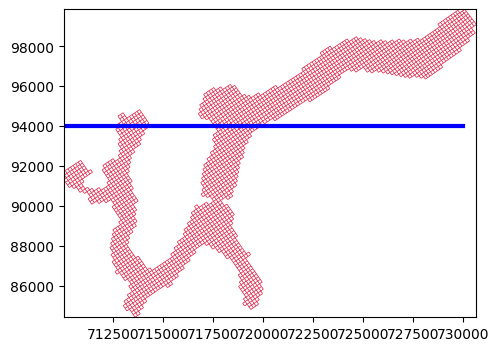

In [6]:
#plot net/grid. use random variable and plot line to get grid
fig, ax = plt.subplots(figsize=(10,4))
pc = uds_map.grid.plot(edgecolor='crimson', linewidth=0.5)
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
if line_array is not None:
    ax.plot(line_array[:,0],line_array[:,1],'b',linewidth=3)


>> rasterizing ugrid Dataset with 1 face variables to shape=(154,207): 0.60 sec


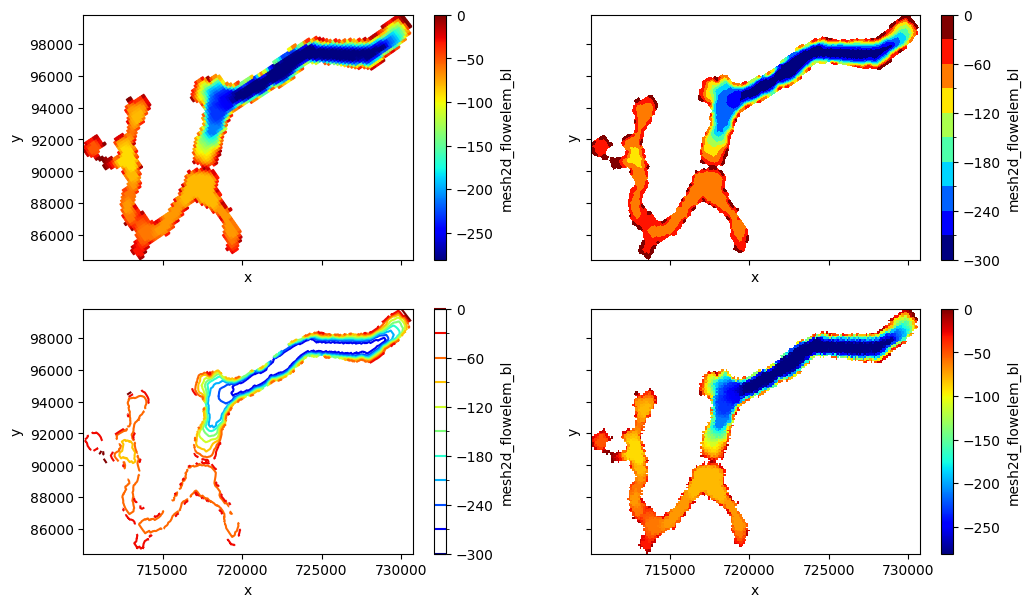

In [7]:
#plot bedlevel on map, including contour/contourf/rasterized
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,7),sharex=True,sharey=True)
pc = uds_map['mesh2d_flowelem_bl'].ugrid.plot(ax=ax1, cmap='jet')
pc = uds_map['mesh2d_flowelem_bl'].ugrid.plot.contourf(ax=ax2, levels=11, cmap='jet')
pc = uds_map['mesh2d_flowelem_bl'].ugrid.plot.contour(ax=ax3, levels=11, cmap='jet', add_colorbar=True)
bl_raster = dfmt.rasterize_ugrid(uds_map[['mesh2d_flowelem_bl']],resolution=raster_res) #rasterize ugrid
pc = bl_raster['mesh2d_flowelem_bl'].plot(ax=ax4, cmap='jet') #plot with non-ugrid method
for ax in (ax1,ax2,ax3,ax4):
    if crs is None:
        ax.set_aspect('equal')
    else:
        ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)


# Plot external forcing

In [8]:
#plot external forcing on map, including windx/windy/air temperature
var1 = 'mesh2d_windx'
var2 = 'mesh2d_windy'
var3 = 'mesh2d_Tair'
var4 = 'mesh2d_Clou'

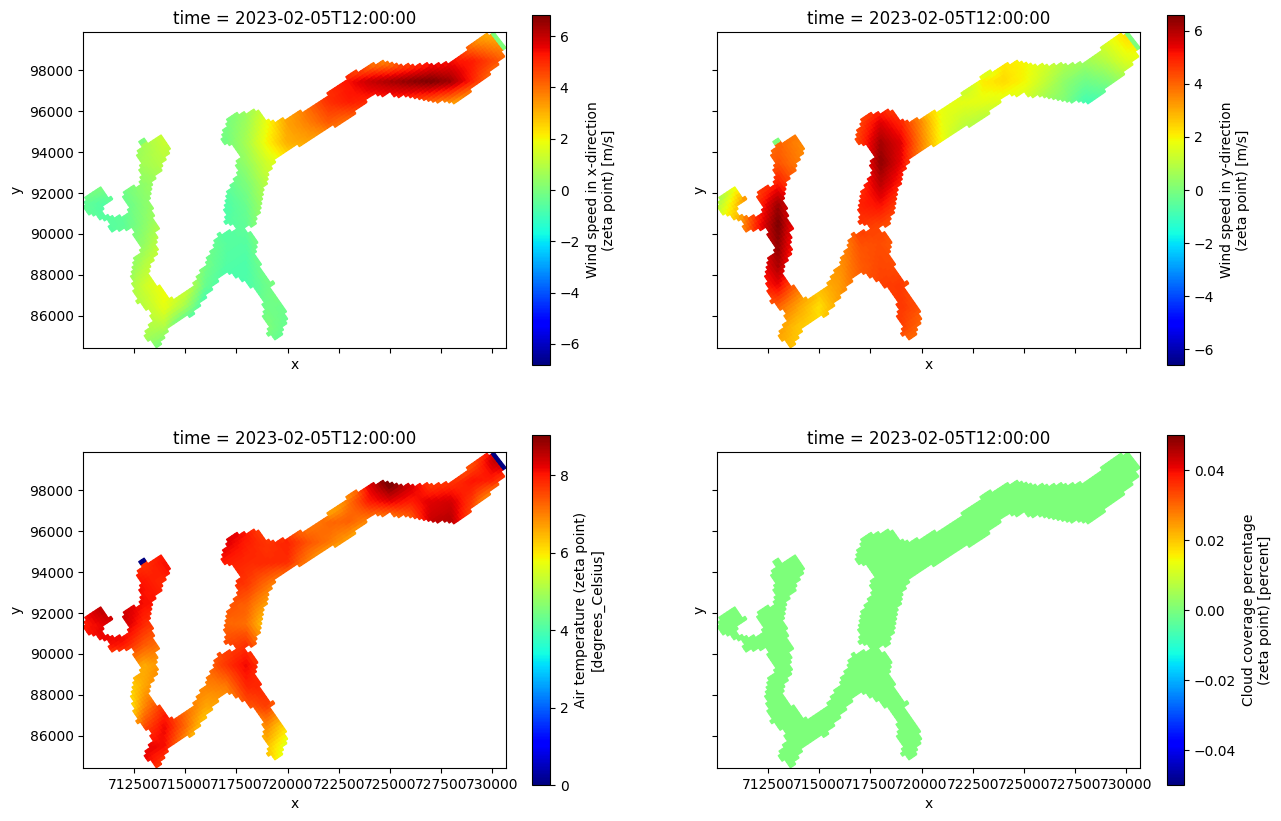

In [9]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(15,10),sharex=True,sharey=True)
pc = uds_map.isel(time=time_plot)[var1].ugrid.plot(ax=ax1, cmap='jet')
pc = uds_map.isel(time=time_plot)[var2].ugrid.plot(ax=ax2, cmap='jet')
pc = uds_map.isel(time=time_plot)[var3].ugrid.plot(ax=ax3, cmap='jet')
pc = uds_map.isel(time=time_plot)[var4].ugrid.plot(ax=ax4, cmap='jet')
for ax in (ax1,ax2,ax3,ax4):
    if crs is None:
        ax.set_aspect('equal')
    else:
        ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)

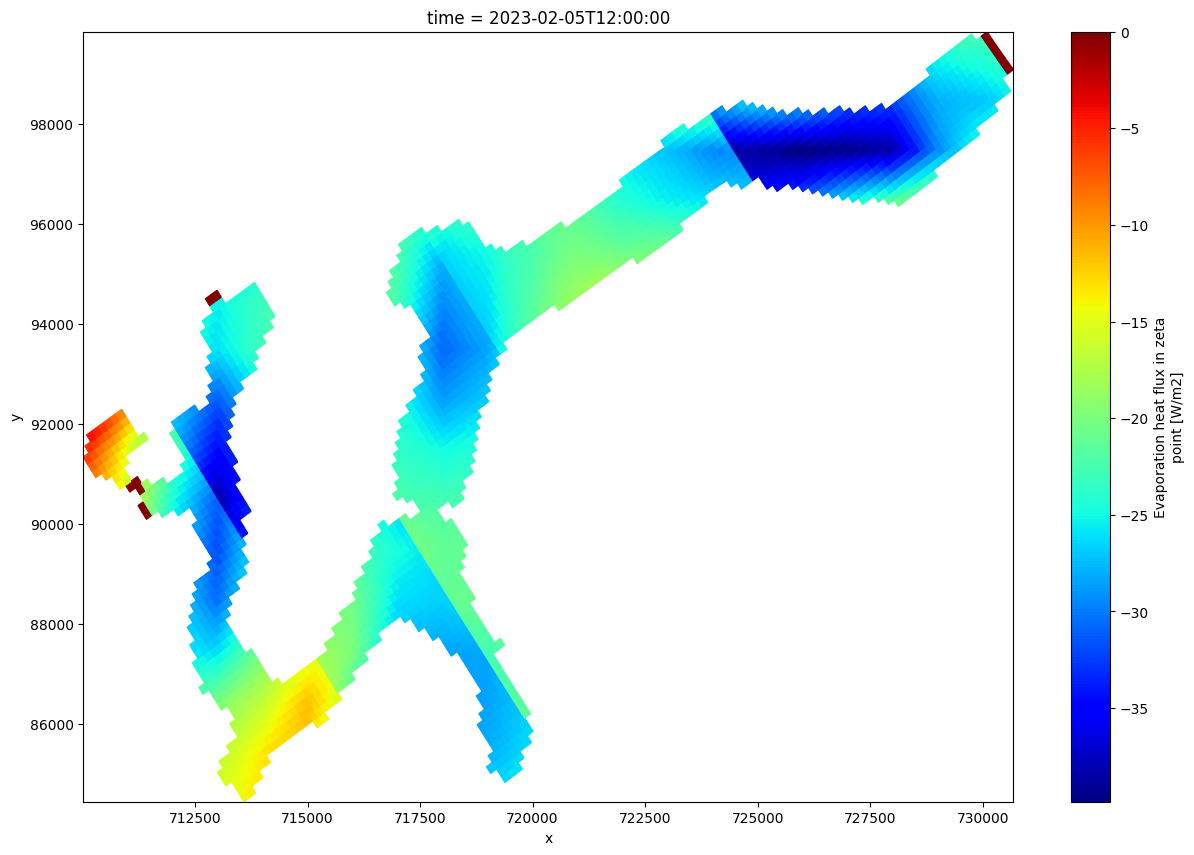

In [10]:
var = 'mesh2d_Qeva'
fig, ax1 = plt.subplots(figsize=(15,10))
pc = uds_map.isel(time=time_plot)[var].ugrid.plot(ax=ax1, cmap='jet')

# Plot water level

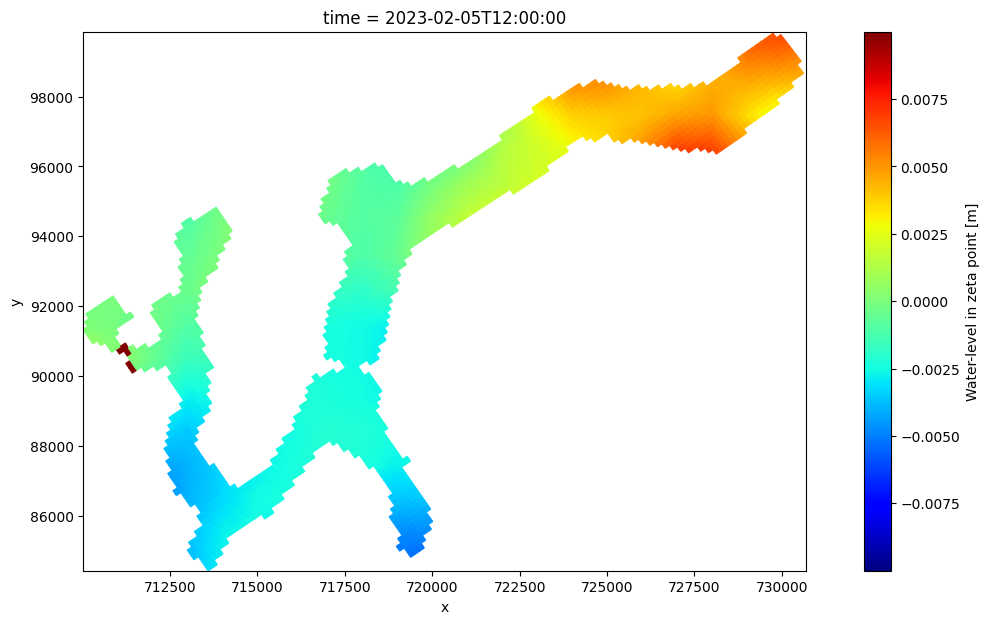

In [11]:
#filter dry cells
bool_drycells = uds_map['mesh2d_s1']==uds_map['mesh2d_flowelem_bl']
uds_map['mesh2d_s1_filt'] = uds_map['mesh2d_s1'].where(~bool_drycells)

#plot water level on map
fig, ax = plt.subplots(figsize=(15,7))
pc = uds_map['mesh2d_s1_filt'].isel(time=time_plot).ugrid.plot(cmap='jet')
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)


# Plot velocities

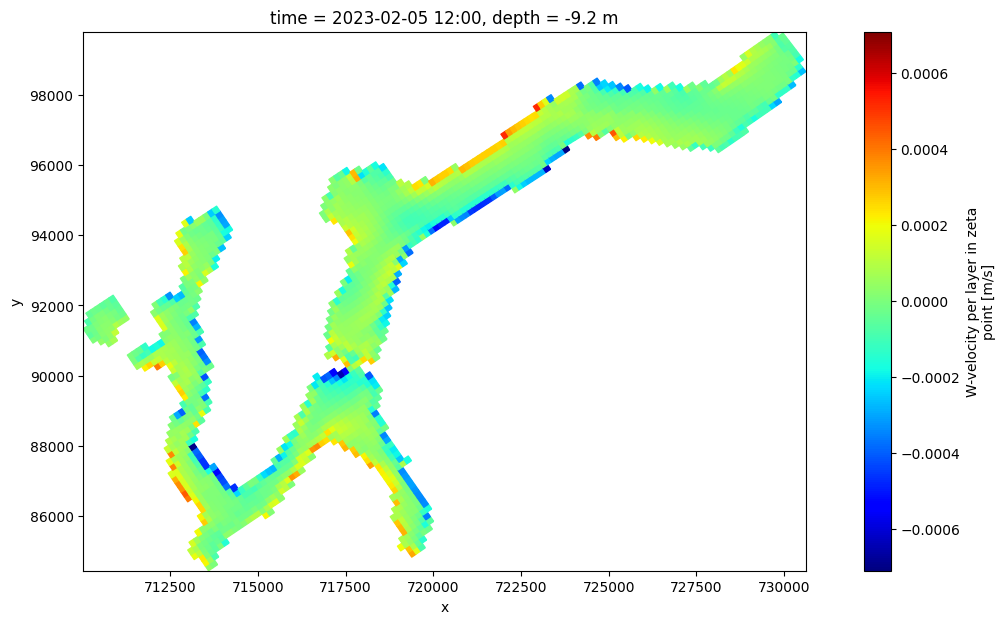

In [12]:
#plot eastward velocities on map, on depth from waterlevel/z0/bedlevel
depth_plot = -10
i_depth_plot = (np.abs(uds_map['mesh2d_layer_z'].values - depth_plot)).argmin()
str_exact_depth_plot = str(round(uds_map["mesh2d_layer_z"].values[i_depth_plot],1))
velocity_nan_mask = uds_map['mesh2d_ucz'].isel(time=time_plot,mesh2d_nLayers=i_depth_plot).values > -100

fig, ax = plt.subplots(figsize=(15,7))
pc = uds_map['mesh2d_ucz'].isel(time=time_plot,mesh2d_nLayers=i_depth_plot)[velocity_nan_mask].ugrid.plot(cmap='jet')
ax.set_title(rf'time = {time_plot_str}, depth = {str_exact_depth_plot} m')
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)


>> rasterizing ugrid Dataset with 2 face variables to shape=(154,207): 0.36 sec


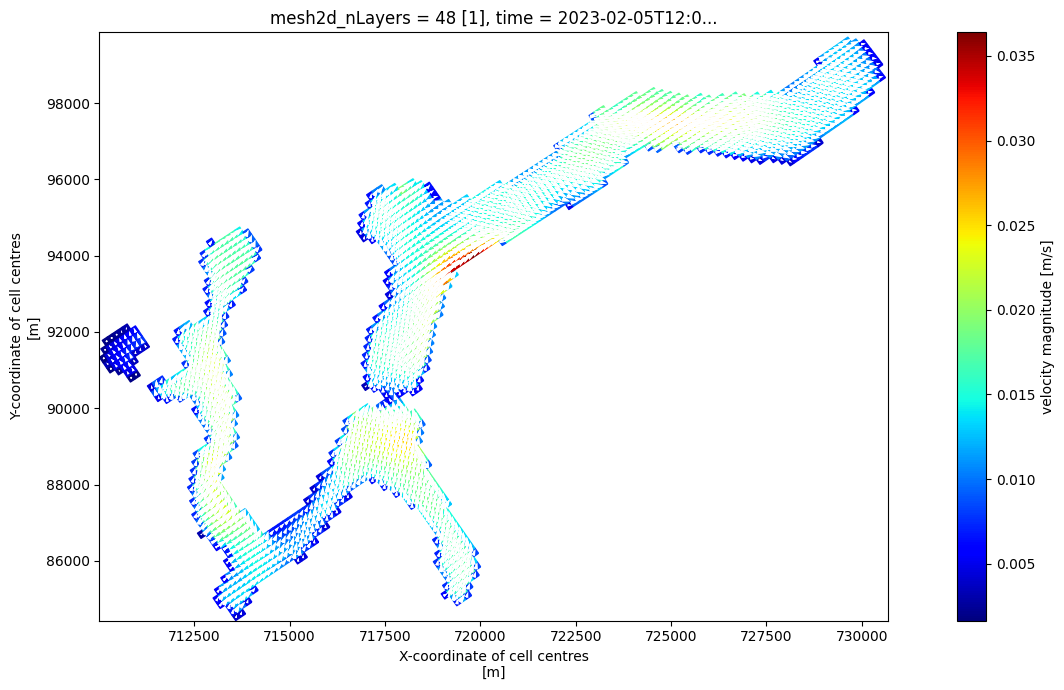

In [19]:
# velocity magnitude and quiver
mesh2d_nLayers = -2 
uds_quiv = uds_map.isel(time=time_plot, mesh2d_nLayers=mesh2d_nLayers,  missing_dims='ignore')
varn_ucx, varn_ucy = 'mesh2d_ucx', 'mesh2d_ucy'
magn_attrs = {'long_name':'velocity magnitude', 'units':'m/s'}
uds_quiv['magn'] = np.sqrt(uds_quiv[varn_ucx]**2+uds_quiv[varn_ucy]**2).assign_attrs(magn_attrs)
raster_quiv = dfmt.rasterize_ugrid(uds_quiv[[varn_ucx,varn_ucy]], resolution=raster_res)

#plot
fig,ax = plt.subplots(figsize=(15,7))
pc = uds_quiv['magn'].ugrid.plot(cmap='jet')
ax.set_title(rf'time = {time_plot_str}, depth = {uds_map["mesh2d_layer_z"].values[mesh2d_nLayers]}m')
raster_quiv.plot.quiver(x='mesh2d_face_x',y='mesh2d_face_y',u=varn_ucx,v=varn_ucy,color='w',scale=1,add_guide=False)
pc.set_clim(umag_clim)
fig.tight_layout()
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)


# Plot temperature

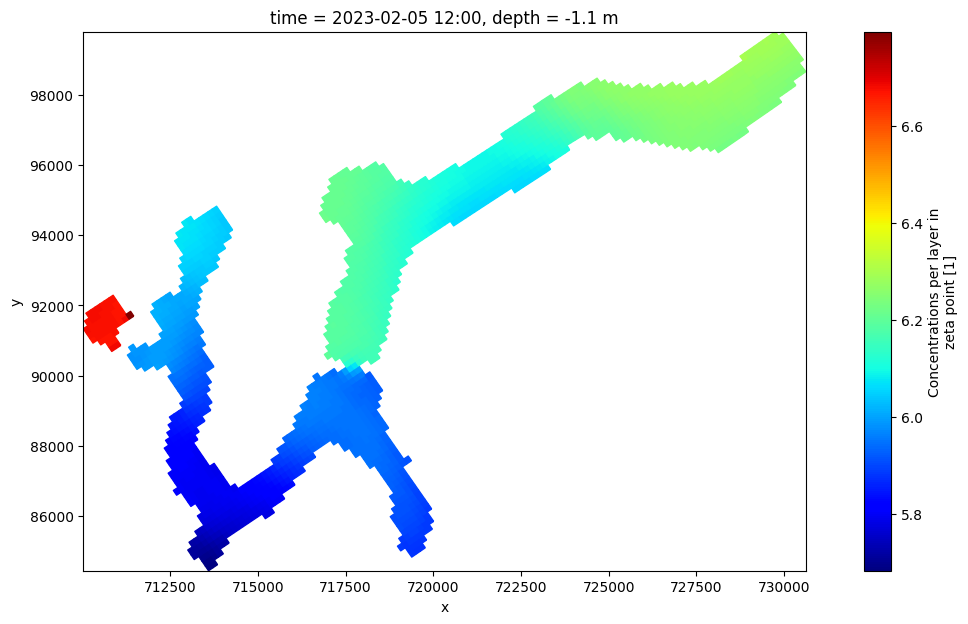

In [14]:
#plot temperature on map, on depth from waterlevel/z0/bedlevel
depth_plot = -0.5
i_depth_plot = (np.abs(uds_map['mesh2d_layer_z'].values - depth_plot)).argmin()
str_exact_depth_plot = str(round(uds_map["mesh2d_layer_z"].values[i_depth_plot],1))
temperature_nan_mask = uds_map['mesh2d_tem1'].isel(time=time_plot,mesh2d_nLayers=i_depth_plot).values > -900

fig, ax = plt.subplots(figsize=(15,7))
pc = uds_map['mesh2d_tem1'].isel(time=time_plot,mesh2d_nLayers=i_depth_plot)[temperature_nan_mask].ugrid.plot(cmap='jet')
ax.set_title(rf'time = {time_plot_str}, depth = {str_exact_depth_plot} m')
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)


ValueError: UgridDataArray contains non-topology dimensions: {'mesh2d_nLayers'}.
Expected only one of {'mesh2d_nEdges', 'mesh2d_nFaces', 'mesh2d_nNodes'}.

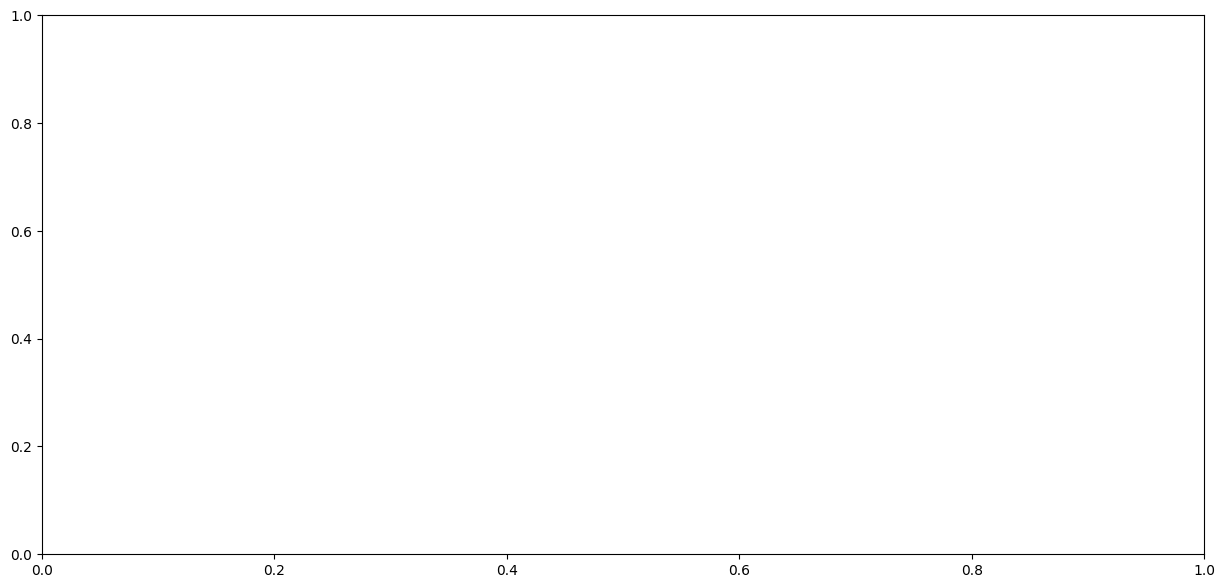

In [15]:
if line_array is not None:
    uds_crs = dfmt.polyline_mapslice(uds_map.isel(time=time_plot), line_array)
    fig, ax = plt.subplots(figsize=(15,7))
    uds_crs['mesh2d_tem1'].ugrid.plot(cmap='jet')

# Reference code
Can be useful but isn't used for the basic plots

### To plot a map using the index of the depth (layer) instead of the depth itself

#plot eastward velocities on map, on layer
fig, ax = plt.subplots(figsize=(15,7))
layer=-1
pc = uds_map['mesh2d_ucx'].isel(time=time_plot,mesh2d_nLayers=layer,nmesh2d_layer=layer,missing_dims='ignore').ugrid.plot(cmap='jet')
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)


### coordinate conversion
if crs == 'EPSG:28992':
    to_crs = 'EPSG:4326'
elif crs == 'EPSG:4326':
    to_crs = 'EPSG:28992'
if crs is not None:
    uds_map.ugrid.set_crs(crs)
    uds_map_conv = uds_map.ugrid.to_crs(to_crs)
    fig, ax = plt.subplots()
    uds_map_conv["mesh2d_waterdepth"].isel(time=0).ugrid.plot(ax=ax)
    ctx.add_basemap(ax=ax, source=None, crs=to_crs, attribution=False)


v1max = float(uds_map[var1].max().values)
v1min = float(uds_map[var1].min().values)
v2max = float(uds_map[var2].max().values)
v2min = float(uds_map[var2].min().values)
v3max = float(uds_map[var3].max().values)
v3min = float(uds_map[var3].min().values)
v4max = float(uds_map[var4].max().values)
v4min = float(uds_map[var4].min().values)

#!! VIDEO !! (takes time)
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(15,7),sharex=True,sharey=True)
pc = uds_map.isel(time=0)[var1].ugrid.plot(ax=ax1, cmap='jet', vmin=v1min, vmax=v1max)
pc = uds_map.isel(time=0)[var2].ugrid.plot(ax=ax2, cmap='jet', vmin=v2min, vmax=v2max)
pc = uds_map.isel(time=0)[var3].ugrid.plot(ax=ax3, cmap='jet', vmin=v3min, vmax=v3max)
pc = uds_map.isel(time=0)[var4].ugrid.plot(ax=ax4, cmap='jet', vmin=v4min, vmax=v4max)
for ax in (ax1,ax2,ax3,ax4):
    if crs is None:
        ax.set_aspect('equal')
    else:
        ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
        
def plot_external_forcings(time) :
    pc1 = uds_map.isel(time=time)[var1].ugrid.plot(ax=ax1, cmap='jet', add_colorbar=False, vmin=v1min, vmax=v1max)
    pc2 = uds_map.isel(time=time)[var2].ugrid.plot(ax=ax2, cmap='jet', add_colorbar=False, vmin=v2min, vmax=v2max)
    pc3 = uds_map.isel(time=time)[var3].ugrid.plot(ax=ax3, cmap='jet', add_colorbar=False, vmin=v3min, vmax=v3max)
    pc4 = uds_map.isel(time=time)[var4].ugrid.plot(ax=ax4, cmap='jet', add_colorbar=False, vmin=v4min, vmax=v4max)
    for ax in (ax1,ax2,ax3,ax4):
        if crs is None:
            ax.set_aspect('equal')
        else:
            ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
    return pc1, pc2, pc3, pc4

ani = FuncAnimation(fig, plot_external_forcings, frames=len(uds_map['time']), blit=True)
ani.save(working_dir+r'\output\external_forcing.gif', fps=5, writer='pillow')

#!! VIDEO !! (takes time)
vtempmin = +999
vtempmax = -999
for i in range(len(uds_map['time'])-1):
    values = dfmt.get_Dataset_atdepths(data_xr=uds_map.isel(time=i), depths=-5, reference='waterlevel') 
    min_temp = float(values['mesh2d_tem1'].min().values)
    max_temp = float(values['mesh2d_tem1'].max().values)
    if min_temp < vtempmin:
        vtempmin = min_temp
    if max_temp > vtempmax:
        vtempmax = max_temp

uds_map_atdepths = dfmt.get_Dataset_atdepths(data_xr=uds_map.isel(time=0), depths=-5, reference='waterlevel')
fig, ax = plt.subplots(figsize=(15,7))
pc = uds_map_atdepths['mesh2d_tem1'].ugrid.plot(cmap='jet', vmin=vtempmin, vmax=vtempmax)
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
        
def plot_surface_temp(time) :
    uds_map_atdepths = dfmt.get_Dataset_atdepths(data_xr=uds_map.isel(time=time), depths=-5, reference='waterlevel')
    ax = uds_map_atdepths['mesh2d_tem1'].ugrid.plot(cmap='jet', add_colorbar=False, vmin=vtempmin, vmax=vtempmax)
    if crs is None:
        ax.set_aspect('equal')
    else:
        ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
    return ax

#ani = FuncAnimation(fig, plot_surface_temp, frames=10, blit=True)
#ani.save(working_dir+r'\output\surface_temp.gif', fps=5, writer='pillow')